In [97]:
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from deepface.commons import functions
from deepface.detectors import FaceDetector
import tensorflow as tf
import cv2
import os
import gdown
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import LogisticRegression
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.calibration import CalibratedClassifierCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import glob
import matplotlib.pyplot as plt
from deepface import DeepFace
import splitfolders
from PIL import Image
from sklearn.metrics import brier_score_loss, roc_auc_score
from IPython.core.interactiveshell import InteractiveShell
from sklearn.calibration import calibration_curve
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)

In [90]:
# # Cropping images using mtcnn and placing them in a different directory
# # Adapted some of the code provided in the Deepface github
# genders = ['female','male']
# path_name = 'C:\\Dev\\midjourney\\sex_detection\\gender'
# target_size = (224, 224)


# for gender in genders:
#     imgs = glob.glob(path_name + '\\' + gender + '\\*')
#     for i in range(len(imgs)):
#         img_name = imgs[i].split('\\')[6]
#         print(img_name)

#         if '.png' in img_name:
#             loaded_img = functions.load_image(imgs[i])
#             base_img = img.copy()

#             img, region = functions.detect_face(loaded_img, enforce_detection = False, detector_backend = 'mtcnn')

#             #---------------------------------------------------
#             if img.shape[0] == 0 or img.shape[1] == 0:
#                 img = base_img.copy()


#             #---------------------------------------------------
#             #resize image to expected shape
#             if img.shape[0] > 0 and img.shape[1] > 0:
#                 factor_0 = target_size[0] / img.shape[0]
#                 factor_1 = target_size[1] / img.shape[1]
#                 factor = min(factor_0, factor_1)

#                 dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
#                 img = cv2.resize(img, dsize)

#                 # Then pad the other side to the target size by adding black pixels
#                 diff_0 = target_size[0] - img.shape[0]
#                 diff_1 = target_size[1] - img.shape[1]

#                 # Put the base image in the middle of the padded image
#                 img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')

#             #------------------------------------------

#             #double check: if target image is not still the same size with target.
#             if img.shape[0:2] != target_size:
#                 img = cv2.resize(img, target_size)


#             image_path = "C:\\Dev\\midjourney\\sex_detection\\gender_bound"
#             filename = image_path + '\\' + gender + '\\' + img_name

#             cv2.imwrite(filename, img) 

In [3]:
# Split data into training, validation, and testing sets
image_path = "C:\\Dev\\midjourney\\sex_detection\\gender_bound"
splitfolders.ratio(image_path, output="C:\\Dev\\midjourney\\sex_detection", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 857 files [00:03, 283.43 files/s]


In [91]:
# VGG-Face base model used in DeepFace
def baseModel():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(256,256, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))

    return model

In [92]:
# Pre-trained weights of VGG-Face model.

url = 'https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5'
model = baseModel()
home = functions.get_deepface_home()
output = home+'/.deepface/weights/vgg_face_weights.h5'

if os.path.isfile(output) != True:
    print("vgg_face_weights.h5 will be downloaded...")
    gdown.download(url, output, quiet=False)


model.load_weights(output)

In [93]:
# Transfer learning for the model, changing the last 3 layers
for layer in model.layers[:-7]:
    layer.trainable = False

    
base_model_output = Sequential()
base_model_output = Convolution2D(2, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
gender_model = Model(inputs=model.input, outputs=base_model_output)
calibrated_gender_model = Model(inputs=model.input, outputs=base_model_output)

In [7]:
gender_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [8]:
# Use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Save best model automatically
mc = ModelCheckpoint(filepath='C:\\Dev\\midjourney\\sex_detection\\final_deepface_model.h5', monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')
cb_list=[es,mc] 

In [9]:
epochs = 50; batch_size = 256
image_size = (256, 256)
class_names = ['female', 'male']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Dev\\midjourney\\sex_detection\\train",
    class_names=class_names,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Dev\\midjourney\\sex_detection\\val",
    class_names=class_names,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 796 files belonging to 2 classes.
Found 144 files belonging to 2 classes.


In [10]:
# # Fit the model

# gender_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=cb_list)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 22.7384 - accuracy: 0.2663  
Epoch 00001: val_loss improved from inf to 0.81922, saving model to C:\Dev\midjourney\sex_detection\final_deepface_model.h5
4/4 [==============================] - 466s 123s/step - loss: 22.7384 - accuracy: 0.2663 - val_loss: 0.8192 - val_accuracy: 0.8056
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 7.6592 - accuracy: 0.6997  
Epoch 00002: val_loss did not improve from 0.81922
4/4 [==============================] - 498s 119s/step - loss: 7.6592 - accuracy: 0.6997 - val_loss: 3.6236 - val_accuracy: 0.8333
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 3.9945 - accuracy: 0.8606  
Epoch 00003: val_loss did not improve from 0.81922
4/4 [==============================] - 528s 127s/step - loss: 3.9945 - accuracy: 0.8606 - val_loss: 1.3409 - val_accuracy: 0.9444
Epoch 00003: early stopping


In [82]:
# Create predictions array

classes = ['female', 'male']
src = 'C:\\Dev\\midjourney\\sex_detection\\val'
scores = []
actual_list = []
predict_probs = []
m_probs = []

for gender in classes:
    gender_imgs = glob.glob(src + '\\' + gender + '\\*')
    for img in gender_imgs:
        if gender == 'female':
            actual_list.append(1)
        else:
            actual_list.append(0)
        img = keras.preprocessing.image.load_img(img, target_size=image_size)
        
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = gender_model.predict(img_array)
        score = predictions[0]
        scores.append(score)
        predict_probs.append(score[0])
        m_probs.append(score[1])
        print(score)
        print(
            "This image is %.2f percent male and %.2f percent female."
            % (100 * (1 - score[0]), 100 * score[0])
        )


1/1 [==============================] - 6s 6s/step
[1.000000e+00 7.524554e-11 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 539ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 519ms/step
[1.0000000e+00 1.3806021e-18 5.4209300e-34 0.0000000e+00 1.0798186e-31
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 538ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 570ms/step
[1.000000e+00 3.274354e-27 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 508ms/step
[1.000000

This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 0s 483ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 518ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 0s 498ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 547ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 0s 488ms/step
[1.00000000e+00 1.47955618e-31 1.20068424e-23 0.00000000e+00
 1.02136500e-32 0.00000000e+00 0.00000000e+00 0.00000000e+00]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 595ms/step
[1. 0. 0. 0. 0. 0. 0. 0.]
This image is 0.00 percent male and 100.00 percent female.
1/1 [===========

 3.5551562e-36 0.0000000e+00 0.0000000e+00]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 582ms/step
[7.158421e-28 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 533ms/step
[0. 1. 0. 0. 0. 0. 0. 0.]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 572ms/step
[0. 1. 0. 0. 0. 0. 0. 0.]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 513ms/step
[0. 1. 0. 0. 0. 0. 0. 0.]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 555ms/step
[1.000000e+00 3.606710e-13 0.000000e+00 0.000000e+00 3.650835e-38
 0.000000e+00 0.000000e+00 0.000000e+00]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 517

[0. 1. 0. 0. 0. 0. 0. 0.]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 525ms/step
[1.0000000e+00 1.7249798e-08 0.0000000e+00 0.0000000e+00 2.6261686e-31
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 513ms/step
[3.7035028e-25 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 525ms/step
[0. 1. 0. 0. 0. 0. 0. 0.]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 570ms/step
[6.1425764e-27 1.0000000e+00 0.0000000e+00 4.1489523e-29 0.0000000e+00
 3.3505774e-31 0.0000000e+00 0.0000000e+00]
This image is 100.00 percent male and 0.00 percent female.


Text(0.5, 0, 'Average Predicted Probability in each bin')

Text(0, 0.5, 'Ratio of positives')

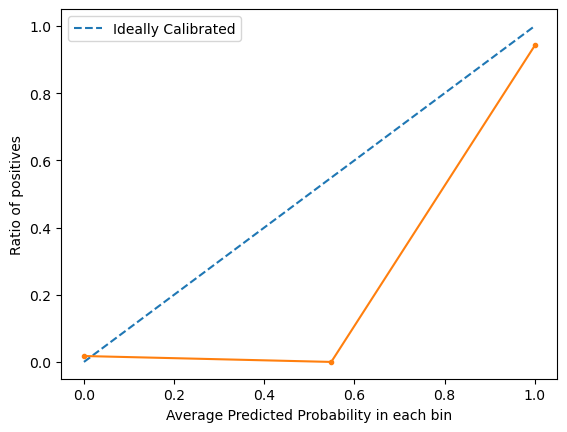

In [77]:
# Diagnose calibration - creating reliability diagram
fop, mpv = calibration_curve(actual_list, predict_probs)
plt.plot([0,1], [0,1], linestyle='--', label = 'Ideally Calibrated')
plt.plot(mpv, fop, marker='.')
plt.xlabel('Average Predicted Probability in each bin') 
plt.ylabel('Ratio of positives') 
plt.legend()
plt.title("Female")
plt.show()

In [81]:
# Brier score and ROC-AUC score
print('Brier score:')
brier_score_loss(actual_list, predict_probs, pos_label=2)
print('--------------------------')
print('ROC-AUC score:')
roc_auc_score(actual_list, predict_probs)

Brier score:


0.5992691418336962

--------------------------
ROC-AUC score:


0.9718725413060582

In [53]:
pred_list = []
for i in scores:
    pred_list.append(np.argmax(i))

In [54]:
for i in range(len(pred_list)):
    if pred_list[i] == 0:
        pred_list[i] = 'female'
    elif pred_list[i] == 1:
        pred_list[i] = 'male'

In [55]:
for i in range(len(actual_list)):
    if actual_list[i] == 1:
        actual_list[i] = 'female'
    elif actual_list[i] == 0:
        actual_list[i] = 'male'

<AxesSubplot: >

Text(0.5, 23.52222222222222, 'Prediction')

Text(50.722222222222214, 0.5, 'Actual')

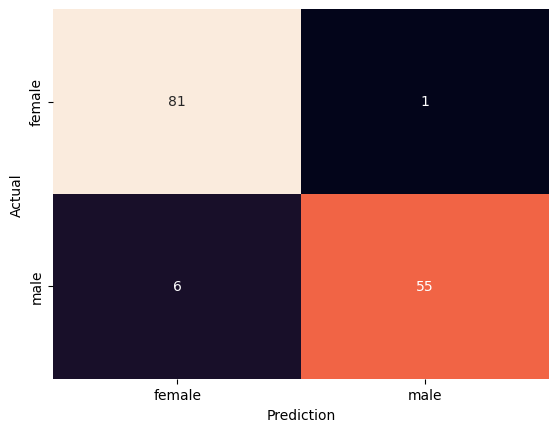

In [56]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
classes = ['female','male']
cf_matrix = confusion_matrix(actual_list, pred_list)
cf_matrix = np.delete(cf_matrix, 0, 0)
cf_matrix = np.delete(cf_matrix, 0, 1)
df_cm = pd.DataFrame(cf_matrix, index = classes,
                  columns = classes)
sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, cbar=False, annot=True, fmt="g")
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [57]:
# Metrics
target_names = ['female', 'male']
print(classification_report(actual_list, pred_list, target_names=target_names, labels=['female','male']))

              precision    recall  f1-score   support

      female       0.93      0.99      0.96        82
        male       0.98      0.89      0.93        62

   micro avg       0.95      0.94      0.95       144
   macro avg       0.96      0.94      0.95       144
weighted avg       0.95      0.94      0.95       144



<h3>Testing Model on Test Set</h3>

In [26]:
from keras.models import load_model

In [27]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Dev\\midjourney\\sex_detection\\test",
    class_names=class_names,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 159 files belonging to 2 classes.


In [28]:
# load a saved model
os.chdir('C:\\Dev\\midjourney\\sex_detection')
saved_model = load_model('final_deepface_model.h5')

In [29]:
# Create predictions array

classes = ['female', 'male']
src = 'C:\\Dev\\midjourney\\sex_detection\\test'

actual_list = []
img_list = []

for gender in classes:
    gender_imgs = glob.glob(src + '\\' + gender + '\\*')
    for img in gender_imgs:
        if gender == 'female':
            actual_list.append(0)
        else:
            actual_list.append(1)
        img = keras.preprocessing.image.load_img(img, target_size=image_size)
        
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = saved_model.predict(img_array)
        score = predictions[0]
        img_list.append(score)
        print(score)
        print(
            "This image is %.2f percent male and %.2f percent female."
            % (100 * (1 - score[0]), 100 * score[0])
        )


1/1 [==============================] - 1s 647ms/step
[9.6585542e-01 3.4122791e-02 1.1654123e-05 2.7711660e-06 5.9667341e-06
 1.3985980e-06 1.4310493e-10 1.2929457e-11]
This image is 3.41 percent male and 96.59 percent female.
1/1 [==============================] - 1s 532ms/step
[1.8469138e-01 8.1529152e-01 1.3952622e-05 2.8755321e-06 2.2078348e-07
 3.5120749e-08 1.8550653e-09 4.7663803e-11]
This image is 81.53 percent male and 18.47 percent female.
1/1 [==============================] - 1s 533ms/step
[9.9517018e-01 4.8297816e-03 7.2233689e-14 1.4351903e-14 1.3933063e-15
 9.2352616e-16 3.3041520e-27 3.6337890e-28]
This image is 0.48 percent male and 99.52 percent female.
1/1 [==============================] - 1s 505ms/step
[9.29433107e-01 7.05668479e-02 3.73658257e-11 1.10976326e-13
 8.65555240e-13 8.78705373e-15 4.38908301e-20 1.55813410e-24]
This image is 7.06 percent male and 92.94 percent female.
1/1 [==============================] - 1s 557ms/step
[1.0000000e+00 5.8197046e-15 5.395

1/1 [==============================] - 1s 523ms/step
[8.55612218e-01 1.44240335e-01 1.07777916e-04 3.65073320e-05
 3.03497927e-06 3.35913057e-08 8.22737933e-10 3.54627720e-12]
This image is 14.44 percent male and 85.56 percent female.
1/1 [==============================] - 0s 488ms/step
[1.0000000e+00 4.8553317e-09 3.2628387e-16 4.7678576e-23 8.0755641e-18
 5.9373368e-24 3.4603243e-25 3.0294039e-34]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 518ms/step
[9.9707067e-01 8.6616463e-04 2.0608138e-03 2.1298767e-06 1.8633493e-07
 5.9845981e-13 1.1617407e-11 1.8160083e-16]
This image is 0.29 percent male and 99.71 percent female.
1/1 [==============================] - 0s 485ms/step
[1.0000000e+00 1.4475847e-14 8.8453393e-13 1.2312660e-21 7.0106408e-16
 2.7861210e-23 3.7104446e-26 7.3098121e-34]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 536ms/step
[4.8673597e-01 5.1322860e-01 3.1

 6.5314477e-23 5.1123837e-27 1.0737092e-34]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 0s 464ms/step
[9.9942017e-01 4.8545006e-04 2.3212837e-05 1.5501972e-09 7.1159899e-05
 9.6330393e-09 2.9937670e-08 7.1281051e-13]
This image is 0.06 percent male and 99.94 percent female.
1/1 [==============================] - 1s 518ms/step
[1.0000000e+00 2.2091620e-09 3.2193100e-14 1.6582810e-18 3.5614908e-16
 1.9503413e-20 3.1710125e-26 2.9220559e-32]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 1s 524ms/step
[9.9998844e-01 4.3802793e-06 1.9344834e-06 2.2787974e-12 5.2534983e-06
 6.6696655e-11 3.7167940e-09 2.9786113e-15]
This image is 0.00 percent male and 100.00 percent female.
1/1 [==============================] - 0s 472ms/step
[3.9949515e-01 3.1159690e-01 4.0635417e-04 2.8078788e-05 2.0343594e-01
 8.0750547e-02 4.0404587e-03 2.4660074e-04]
This image is 60.05 percent male and 39.95 percen

 4.3465932e-19 3.8190652e-26 1.1185375e-30]
This image is 89.23 percent male and 10.77 percent female.
1/1 [==============================] - 1s 524ms/step
[2.3636178e-05 9.6900195e-01 1.5225563e-06 3.0972833e-02 8.7078060e-09
 9.9500198e-08 2.7206587e-10 1.3983724e-09]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 526ms/step
[5.4878735e-16 1.0000000e+00 1.3696293e-24 1.2839653e-17 7.0911953e-24
 2.9839538e-17 5.9142812e-31 2.0215531e-28]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 507ms/step
[1.7056188e-11 1.0000000e+00 2.7501534e-17 9.5038647e-13 4.0352625e-18
 2.1590446e-13 4.4293542e-24 6.7725640e-23]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 1s 525ms/step
[3.5216626e-02 9.6478337e-01 5.7125425e-13 2.3995601e-14 1.7231161e-16
 6.4209577e-17 2.1310934e-25 1.8330813e-29]
This image is 96.48 percent male and 3.52 percen

 4.6067257e-13 3.3823815e-21 2.5813291e-22]
This image is 99.99 percent male and 0.01 percent female.
1/1 [==============================] - 0s 472ms/step
[6.7921918e-10 9.9999964e-01 1.5856576e-13 3.8872099e-07 1.9557797e-12
 3.6728327e-09 1.2593578e-15 3.2359074e-13]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 0s 478ms/step
[4.9295972e-14 1.0000000e+00 5.2432457e-22 6.1693848e-15 3.7332697e-21
 9.8161171e-14 3.7250480e-28 2.5556048e-24]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 0s 476ms/step
[6.7336572e-07 9.9999928e-01 4.9653982e-13 5.8623209e-09 9.9122481e-11
 2.1954498e-09 2.9558246e-15 2.1397725e-15]
This image is 100.00 percent male and 0.00 percent female.
1/1 [==============================] - 0s 469ms/step
[1.1511110e-12 1.0000000e+00 2.8183987e-19 4.4777975e-13 3.0913755e-23
 2.6317924e-18 2.1579821e-28 2.9759491e-26]
This image is 100.00 percent male and 0.00 percen

In [30]:
pred_list = []
for i in img_list:
    pred_list.append(np.argmax(i))

In [31]:
for i in range(len(pred_list)):
    if pred_list[i] == 0:
        pred_list[i] = 'female'
    elif pred_list[i] == 1:
        pred_list[i] = 'male'

In [32]:
for i in range(len(actual_list)):
    if actual_list[i] == 0:
        actual_list[i] = 'female'
    elif actual_list[i] == 1:
        actual_list[i] = 'male'

<AxesSubplot: >

Text(0.5, 23.52222222222222, 'Prediction')

Text(50.722222222222214, 0.5, 'Actual')

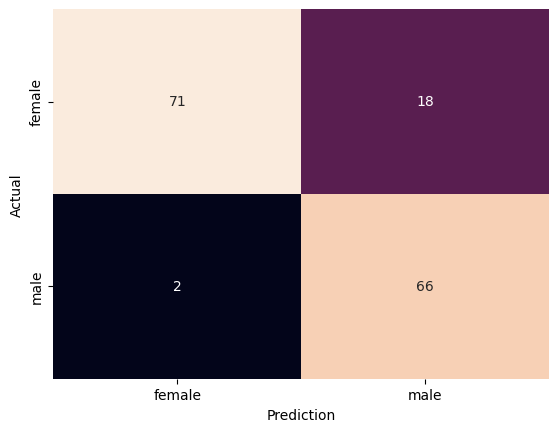

In [35]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
classes = ['female','male']
cf_matrix = confusion_matrix(actual_list, pred_list)
cf_matrix = np.delete(cf_matrix, 0, 0)
cf_matrix = np.delete(cf_matrix, 0, 1)
cf_matrix = np.delete(cf_matrix, 0, 0)
cf_matrix = np.delete(cf_matrix, 0, 1)
df_cm = pd.DataFrame(cf_matrix, index = classes,
                  columns = classes)
sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, cbar=False, annot=True, fmt="g")
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [36]:
# Metrics
target_names = ['female', 'male']
print(classification_report(actual_list, pred_list, target_names=target_names, labels=['female','male']))

              precision    recall  f1-score   support

      female       0.97      0.79      0.87        90
        male       0.79      0.96      0.86        69

   micro avg       0.87      0.86      0.87       159
   macro avg       0.88      0.87      0.87       159
weighted avg       0.89      0.86      0.87       159

